# Monte Carlo Simulations

This notebook uses Monte Carlo system to simulate football matches to get a prediction of the next score

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
import multiprocessing
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

In [3]:
seasons = [2024]
leagues_dictionary = {
    'MX1': 31,
    'BR1': 24,
    'ARG1': 21,
    'MLS': 22,
    'ENG1': 9,
    'ESP1': 12,
    'ITA1': 11,
    'GER1': 20,
    'FRA1': 13,
    'HOL1': 23,
    'POR1': 32

}

df_sum = pd.DataFrame()
df_def = pd.DataFrame()

for league, code in leagues_dictionary.items():
    for season in seasons:
        sum_temp = pd.read_parquet("Data/{}/{}_{}_Sum.gzip".format(league, league, season))
        def_temp = pd.read_parquet("Data/{}/{}_{}_Def.gzip".format(league, league, season))
        sum_temp['league'], def_temp['league'], sum_temp['code'], def_temp['code'], sum_temp['season'], def_temp['season'] = league, league, code, code, season, season

        df_sum = pd.concat([df_sum, sum_temp])
        df_def = pd.concat([df_def, def_temp])  
        
df_sum['key'] = df_sum['match'] + "|" + df_sum["team"] + "|" + df_sum['rival'] + "|" + df_sum['league']
        
match_list = df_sum.groupby(['match', 'season']).agg(winner=('winner', 'first'),
                                                 league=('league', 'first'),
                                                 date=('date', 'first'),
                                                     time=('time', 'first'),
                                                    stadium=('stadium','first')).reset_index()

match_list['home_team'] = match_list['match'].str.split('-').str[0]
match_list['away_team'] = match_list['match'].str.split('-').str[1]

In [4]:
match_list['home_team'].value_counts()

FC            263
Real          261
Atlético      260
América       185
Santos        180
             ... 
Estrela         9
Veracruz        9
Le              9
Heidenheim      8
Almere          8
Name: home_team, Length: 266, dtype: int64

In [4]:
# Last 5 matches from match id

# Esta funcion devuelve dos dataframes, con todos los registros de los jugadores en los ultimos 5 partidos jugados antes de un partido definido en los parametros.
# Recibe 2 parametros
# - match_id: El id del partido en el cual nos basaremos para obtener los ultimos 5 partidos.
# - team: El equipo del que obtendremos los ultimos 5 partidos.


def last_5_m(match_id, team, t_league):
    
    match_list['date'] = pd.to_datetime(match_list['date'])
        
    c_match = match_list[match_list['match']==match_id]
    date = c_match['date'].values[0]
    
    match_sort = match_list[match_list['league'] == t_league]

    match_sort = match_sort[match_sort['date'].dt.tz_localize(None) < pd.to_datetime(date).tz_localize(None)].sort_values(by="date", ascending=False).head(50)
    
    return df_sum[(df_sum['match'].isin(match_sort['match'].values)) & (df_sum['league'] == t_league)].sort_values(by="date", ascending=False).reset_index(drop=True), df_def[(df_def['match'].isin(match_sort['match'].values)) & (df_def['league'] == t_league)].sort_values(by="date", ascending=False).reset_index(drop=True)

def all_matches_sum(match_id, team, t_league):
    
    match_list['date'] = pd.to_datetime(match_list['date'])
        
    c_match = match_list[match_list['match']==match_id]
    date = c_match['date'].values[0]
    
    match_sort = match_list[match_list['league'] == t_league]

    match_sort = match_sort[match_sort['date'].dt.tz_localize(None) < pd.to_datetime(date).tz_localize(None)].sort_values(by="date", ascending=False)
    
    return df_sum[df_sum['match'].isin(match_sort['match'].values)].sort_values(by="date", ascending=False).reset_index(drop=True), df_def[df_def['match'].isin(match_sort['match'].values)].sort_values(by="date", ascending=False).reset_index(drop=True)

def season_matches_sum(match_id, team, t_season, t_league):
    
    match_list['date'] = pd.to_datetime(match_list['date'])
        
    c_match = match_list[match_list['match']==match_id]
    date = c_match['date'].values[0]
    
    match_sort = match_list[match_list['league'] == t_league]

    match_sort = match_sort[match_sort['date'].dt.tz_localize(None) < pd.to_datetime(date).tz_localize(None)].sort_values(by="date", ascending=False)
    
    match_sort = match_sort[match_sort['season'] == t_season]
    
    return df_sum[df_sum['match'].isin(match_sort['match'].values)].sort_values(by="date", ascending=False).reset_index(drop=True), df_def[df_def['match'].isin(match_sort['match'].values)].sort_values(by="date", ascending=False).reset_index(drop=True)

In [5]:
# Get A-Power 
def a_power(df_temp):
    df_temp = df_temp[['team', 'Gls', 'Ast', 'Sh', 'SoT', 'SCA', 'GCA']]
    df_temp = df_temp.groupby(['team']).mean()

    df_prop = df_temp.copy()
    df_prop['Gls'] = (df_prop['Gls'] / max(df_prop['Gls'])) * 5
    df_prop['Ast'] = (df_prop['Ast'] / max(df_prop['Ast'])) * 2
    df_prop['Sh'] = (df_prop['Sh'] / max(df_prop['Sh'])) * 0.5
    df_prop['SoT'] = (df_prop['SoT'] / max(df_prop['SoT']))
    df_prop['SCA'] = (df_prop['SCA'] / max(df_prop['SCA'])) * 0.5
    df_prop['GCA'] = (df_prop['GCA'] / max(df_prop['GCA']))

    df_prop['a_power'] = (df_prop['Gls'] + df_prop['Ast'] + df_prop['Sh'] + df_prop['SoT'] + df_prop['SCA'] + df_prop['GCA']) / 10

    return df_prop[['a_power']] / max(df_prop['a_power'])

# Get D-Power
def d_power(df_temp):
    df_temp = df_temp[['team', 'tc_gls', 'Tkl', 'TklW', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int']].groupby(['team']).mean()
    
    df_temp['tc_gls'] = (df_temp['tc_gls'] / max(df_temp['tc_gls'])) * (-4)
    df_temp['Tkl'] = (df_temp['Tkl'] / max(df_temp['Tkl'])) 
    df_temp['TklW'] = (df_temp['TklW'] / max(df_temp['TklW'])) * 4
    df_temp['Lost'] = (df_temp['Lost'] / max(df_temp['Lost'])) * (-3)
    df_temp['Blocks'] = (df_temp['Blocks'] / max(df_temp['Blocks'])) * 3 
    df_temp['Sh'] = (df_temp['Sh'] / max(df_temp['Sh'])) * 4
    df_temp['Pass'] = (df_temp['Pass'] / max(df_temp['Pass'])) * 4
    df_temp['Int'] = (df_temp['Int'] / max(df_temp['Int'])) * 4

    df_temp['d_power'] = (df_temp['tc_gls'] + df_temp['Tkl'] + df_temp['TklW'] + df_temp['Lost'] + df_temp['Blocks'] + df_temp['Sh'] + df_temp['Pass'] + df_temp['Int']) 
    
    return df_temp[['d_power']] / max(df_temp['d_power'])

In [5]:
# Get A-Power
def a_power(df_temp):
    columns_to_normalize = ['Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks',
                         'xG', 'npxG', 'xAG', 'SCA', 'GCA', 'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'Att.1', 'Succ']
    scaler = StandardScaler()
    df_normalized = df_temp[columns_to_normalize].copy()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_normalized), columns=columns_to_normalize)
    
    df_normalized[['Player', 'team', 'match']] = df_temp[['Player', 'team', 'match']].values
    
    weights = {
    'Min': 0.05,
    'Gls': 0.15,
    'Ast': 0.1,
    'PK': 0.05,
    'PKatt': -0.05,  # Penaliza intentos de penalti
    'Sh': 0.05,
    'SoT': 0.1,
    'CrdY': -0.05,  # Penaliza tarjetas amarillas
    'CrdR': -0.1,   # Penaliza tarjetas rojas
    'Touches': 0.1,
    'Tkl': 0.1,
    'Int': 0.1,
    'Blocks': 0.05,
    'xG': 0.1,
    'npxG': 0.1,
    'xAG': 0.05,
    'SCA': 0.1,
    'GCA': 0.1,
    'Cmp': 0.1,
    'Att': 0.1,
    'Cmp%': 0.05,
    'PrgP': 0.05,
    'Carries': 0.1,
    'PrgC': 0.05,
    'Att.1': 0.1,
    'Succ': 0.1,
    }
    
    for column in columns_to_normalize:
        df_normalized[column] *= weights[column]
    
    df_normalized['Total_Score'] = df_normalized.sum(axis=1)
    
    df_normalized = df_normalized.groupby('team').mean().reset_index()

    # Calcula los cuantiles para determinar los buckets
    quantiles = df_normalized['Total_Score'].quantile([0.25, 0.5, 0.75])

    def categorize_performance(score):
        if score <= quantiles.iloc[0]:
            return 'bad'
        elif quantiles.iloc[0] < score <= quantiles.iloc[1]:
            return 'mid-bad'
        elif quantiles.iloc[1] < score <= quantiles.iloc[2]:
            return 'mid-good'
        else:
            return 'good'

    # Aplica la función a la columna 'Total_Score' para crear la nueva columna 'Performance_Category'
    df_normalized['bucket'] = df_normalized['Total_Score'].apply(categorize_performance)
    
    return df_normalized[['team', 'Total_Score']]

In [7]:
def d_power(df_temp):
    columns_to_normalize = ['Min', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 't_gls', 'tc_gls']

    scaler = StandardScaler()
    df_normalized = df_temp[columns_to_normalize].copy()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_normalized), columns=columns_to_normalize)

    df_normalized[['Player', 'team', 'match']] = df_temp[['Player', 'team', 'match']].values
    
    weights = {
    'Min': 0.05,
    'Tkl': 0.1,
    'TklW': 0.05,
    'Def 3rd': 0.1,
    'Mid 3rd': 0.1,
    'Att 3rd': 0.1,
    'Tkl%': 0.05,
    'Lost': -0.05,
    'Blocks': 0.05,
    'Sh': 0.05,
    'Pass': 0.1,
    'Int': 0.1,
    'Tkl+Int': 0.1,
    'Clr': 0.05,
    'Err': -0.05,
    't_gls': 0.15,
    'tc_gls': -0.15,  # Penalizamos own goals
    }
    
    for column in columns_to_normalize:
        df_normalized[column] *= weights[column]
        
    df_normalized['Total_Score'] = df_normalized.sum(axis=1)
    
    df_normalized = df_normalized.groupby('team').mean().reset_index()

    # Calcula los cuantiles para determinar los buckets
    quantiles = df_normalized['Total_Score'].quantile([0.25, 0.5, 0.75])

    def categorize_performance(score):
        if score <= quantiles.iloc[0]:
            return 'bad'
        elif quantiles.iloc[0] < score <= quantiles.iloc[1]:
            return 'mid-bad'
        elif quantiles.iloc[1] < score <= quantiles.iloc[2]:
            return 'mid-good'
        else:
            return 'good'

    # Aplica la función a la columna 'Total_Score' para crear la nueva columna 'Performance_Category'
    df_normalized['bucket'] = df_normalized['Total_Score'].apply(categorize_performance)
    
    return df_normalized[['team', 'Total_Score']]


In [8]:
def a_bucket_per_match(key):
    try:
        k_split = key.split('|')

        t_match = k_split[0]
        t_team = k_split[1]
        t_rival = k_split[2]
        t_league = k_split[3]
        t_season = int(t_match[-10:-6])


        # Own Buckets

        # Obtenemos los dataframes
        o_df_all = all_matches_sum(t_match, t_team, t_league)[0]
        o_df_season = season_matches_sum(t_match, t_team, t_season, t_league)[0]
        o_df_last5 = last_5_m(t_match, t_team, t_league)[0]

        # Obtenemos los powers
        a_power_all = a_power(o_df_all)
        a_power_season = a_power(o_df_season)
        a_power_last5 = a_power(o_df_last5)

        o_buckets = a_power_all.merge(a_power_season, on="team", suffixes=["_all","_season"], how="left").merge(a_power_last5, on='team', suffixes=["_all","_season", "_last5"], how="left")

        o_buckets.dropna(subset=['Total_Score'],inplace=True)

        o_buckets['total'] = o_buckets['Total_Score_all'] + (o_buckets['Total_Score_season'] * 1) + (o_buckets['Total_Score'] * 2)

        quantiles = o_buckets['total'].quantile([0.25, 0.75])

        def categorize_performance(score):
            if score <= quantiles.iloc[0]:
                return 'bad'
            elif score >= quantiles.iloc[1]:
                return 'good'
            else:
                return 'mid'

        # Aplica la función a la columna 'Total_Score' para crear la nueva columna 'Performance_Category'
        o_buckets['a_bucket'] = o_buckets['total'].apply(categorize_performance)

        return o_buckets[o_buckets['team'] == t_team]['a_bucket'].values[0], o_buckets[o_buckets['team'] == t_team]['total'].values[0]
    except:
        return ''
    
def d_bucket_per_match(key):
    try:
        k_split = key.split('|')

        t_match = k_split[0]
        t_team = k_split[1]
        t_rival = k_split[2]
        t_league = k_split[3]
        t_season = int(t_match[-10:-6])

        # Own Buckets

        # Obtenemos los dataframes
        df_all = all_matches_sum(t_match, t_team, t_league)[1]
        df_season = season_matches_sum(t_match, t_team, t_season, t_league)[1]
        df_last5 = last_5_m(t_match, t_team, t_league)[1]

        d_power_all = d_power(df_all)
        d_power_season = d_power(df_season)
        d_power_last5 = d_power (df_last5)

        d_buckets = d_power_all.merge(d_power_season, on="team", suffixes=['_all', '_season'], how='left').merge(d_power_last5, how='left', on='team')

        d_buckets.dropna(subset=['Total_Score'],inplace=True)

        d_buckets['total'] = d_buckets['Total_Score_all'] + (d_buckets['Total_Score_season'] * 1) + (d_buckets['Total_Score'] * 2)
        
        quantiles = d_buckets['total'].quantile([0.25, 0.75])

        def categorize_performance(score):
            if score <= quantiles.iloc[0]:
                return 'bad'
            elif score >= quantiles.iloc[1]:
                return 'good'
            else:
                return 'mid'

        # Aplica la función a la columna 'Total_Score' para crear la nueva columna 'Performance_Category'
        d_buckets['d_bucket'] = d_buckets['total'].apply(categorize_performance)

        return d_buckets[d_buckets['team'] == t_rival]['d_bucket'].values[0], d_buckets[d_buckets['team'] == t_rival]['total'].values[0]
    except: 
        return ''
    
a_bucket_per_match("UANLAmérica2023-11-11|UANL|América|MX1")[1]

IndexError: string index out of range

In [9]:
test = df_sum.groupby('key').sum()

test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27568 entries, ADOAZ2019-09-22|ADO|AZ|HOL1 to ZwolleWillem2022-01-14|Zwolle|Willem|HOL1
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   #        27568 non-null  float64
 1   Min      27568 non-null  float64
 2   Gls      27568 non-null  int64  
 3   Ast      27568 non-null  int64  
 4   PK       27568 non-null  int64  
 5   PKatt    27568 non-null  int64  
 6   Sh       27568 non-null  int64  
 7   SoT      27568 non-null  int64  
 8   CrdY     27568 non-null  int64  
 9   CrdR     27568 non-null  int64  
 10  Touches  27568 non-null  float64
 11  Tkl      27568 non-null  float64
 12  Int      27568 non-null  int64  
 13  Blocks   27568 non-null  float64
 14  xG       27568 non-null  float64
 15  npxG     27568 non-null  float64
 16  xAG      27568 non-null  float64
 17  SCA      27568 non-null  float64
 18  GCA      27568 non-null  float64
 19  Cmp      27568 non-null  float6

In [10]:
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=7)

mx_sample = df_sum[df_sum['season']!=2020]

mx_sample = mx_sample.groupby(['key']).agg(sum).reset_index()

def process_sample(row):
    a_bucket_result = a_bucket_per_match(row['key'])
    d_bucket_result = d_bucket_per_match(row['key'])

    row['own_ab'] = a_bucket_result[0] if len(a_bucket_result) > 0 else None
    row['rival_db'] = d_bucket_result[0] if len(d_bucket_result) > 0 else None
    row['own_ap'] = a_bucket_result[1] if len(a_bucket_result) > 1 else None
    row['rival_dp'] = d_bucket_result[1] if len(d_bucket_result) > 1 else None  # Fix the condition here
    return row

mx_sample = mx_sample.parallel_apply(process_sample, axis=1)

mx_sample

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,key,#,Min,Gls,Ast,PK,PKatt,Sh,SoT,CrdY,CrdR,Touches,Tkl,Int,Blocks,xG,npxG,xAG,SCA,GCA,Cmp,Att,Cmp%,PrgP,Carries,PrgC,Att.1,Succ,t_gls,tc_gls,season,code,own_ab,rival_db,own_ap,rival_dp
0,ADOAZ2020-10-25|ADO|AZ|HOL1,238.0,990.0,2,2,0,0,9,3,2,0,554.0,12.0,14,12.0,0.6,0.6,0.7,18.0,4.0,322.0,435.0,1134.2,24.0,315.0,8.0,19.0,13.0,32,32,32336,368,bad,mid,-1.457934,0.019168
1,ADOAZ2020-10-25|AZ|ADO|HOL1,147.0,990.0,2,1,0,0,23,7,1,0,718.0,16.0,17,7.0,2.2,2.2,2.2,41.0,3.0,483.0,604.0,939.3,64.0,387.0,26.0,17.0,12.0,24,24,24252,276,good,bad,0.850901,-0.614716
2,ADOAjax2020-12-20|ADO|Ajax|HOL1,277.0,990.0,2,2,0,0,5,3,0,0,490.0,29.0,15,13.0,0.6,0.6,0.5,10.0,4.0,233.0,334.0,1108.9,19.0,201.0,11.0,11.0,8.0,32,64,32336,368,bad,good,-1.802069,0.925835
3,ADOAjax2020-12-20|Ajax|ADO|HOL1,246.0,990.0,4,4,0,0,30,12,0,0,937.0,12.0,6,6.0,3.9,3.9,2.5,49.0,7.0,703.0,808.0,1271.0,77.0,513.0,26.0,23.0,11.0,60,30,30315,345,good,bad,2.364227,-0.913112
4,ADOEmmen2021-01-23|ADO|Emmen|HOL1,350.0,990.0,0,0,0,0,13,4,2,0,554.0,17.0,13,13.0,0.6,0.6,0.4,20.0,0.0,311.0,429.0,1036.0,31.0,263.0,19.0,15.0,12.0,0,0,28294,322,bad,bad,-1.647092,-1.024885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21944,ZwolleVitesse2021-08-15|Zwolle|Vitesse|HOL1,201.0,990.0,0,0,0,0,15,5,0,0,607.0,22.0,15,12.0,1.4,1.4,1.5,29.0,0.0,344.0,467.0,1063.0,30.0,350.0,14.0,17.0,8.0,0,15,30330,345,mid,bad,-0.126691,-0.205143
21945,ZwolleWillem2020-10-24|Willem|Zwolle|HOL1,238.0,990.0,0,0,0,0,13,3,1,0,489.0,17.0,16,16.0,0.8,0.8,0.8,20.0,0.0,240.0,363.0,1047.2,17.0,248.0,19.0,13.0,12.0,0,0,32336,368,mid,bad,-0.202637,-0.446987
21946,ZwolleWillem2020-10-24|Zwolle|Willem|HOL1,202.0,983.0,0,0,0,0,19,4,3,1,620.0,8.0,9,9.0,0.8,0.8,0.7,31.0,0.0,398.0,524.0,989.6,48.0,327.0,17.0,16.0,9.0,0,0,26273,299,mid,mid,-0.074736,-0.104505
21947,ZwolleWillem2022-01-14|Willem|Zwolle|HOL1,256.0,990.0,0,0,0,0,7,0,1,0,595.0,24.0,9,14.0,0.6,0.6,0.6,13.0,0.0,308.0,475.0,1041.8,33.0,274.0,13.0,21.0,12.0,0,32,32352,368,bad,bad,-0.932012,-0.629416


In [11]:
match_buckets = mx_sample.reset_index()[['key', 'own_ab', 'rival_db', 'own_ap', 'rival_dp']]
df_sum = df_sum.merge(match_buckets, on="key")
df_sum.to_csv("mega_df_sum_w_buckets.csv")

In [12]:
# Funcion que simula los goles.
def gls_sim(player, df_temp, bucket):
    try:
        df_temp = df_temp[df_temp['Player']==player]
        df_sort = df_temp[df_temp['rival_db']==bucket]

        if df_sort.empty:
            sample_gls = df_temp.sample(n=1, weights="season")["Gls"]
        else:
            sample_gls = df_sort.sample(n=1, weights="season")["Gls"]

        sample_gls = sample_gls.item()
        return sample_gls
    except:
        print(player)

In [13]:
def squad_sim(team, injured=[]):
    
    start_squad = []
    subs = []
    
    df_temp = df_sum[df_sum['team'] == team]
    
    line_up_list = df_temp.groupby(["formacion", "date"]).agg('sum').sort_values(by='date', ascending=False).reset_index().head()['formacion']
    matches_temp = df_temp.groupby(["match", "date"]).agg('sum').sort_values(by='date', ascending=False).reset_index().head()['match']
    
    df_temp = df_temp[df_temp['match'].isin(matches_temp)].sort_values(by='date', ascending=False)
    df_temp = df_temp[df_temp['Pos'] != "GK"]
    
    df_line_up = df_temp[df_temp['match'].isin(matches_temp)].sort_values(by='date', ascending=False)
    df_line_up = df_line_up[['formacion', 'Min']].groupby('formacion').sum().sort_values(by='Min', ascending=False)
    
    
    player_roster = df_temp[['Player', 'Min']].groupby(['Player']).sum()
    
    # Concatenate the 'Pos' values in each group
    player_roster['Pos'] = df_temp.groupby('Player')['Pos'].apply(lambda x: ','.join(x))
    
    # Remove duplicate 'Pos' values in each group
    player_roster['Pos'] = player_roster['Pos'].apply(lambda x: ','.join(set(x.split(','))))
    
    # Remove injured players
    player_roster = player_roster[~player_roster.index.isin(injured)].sort_values(by='Min', ascending=False)
    
    line_up = df_line_up.sample(n=1).index[0].split('-')
    
    def_positions = ['LB', 'RB', 'CB', 'LW', 'WB']
    mid_positions = ['CM', 'AM', 'LM', 'RM', 'RW', 'LW', 'DM']
    forward = ['FW']
    
    try:
        if len(line_up) == 3:
            # Defensive Players.
            if int(line_up[0]) == 3:
                temp_list = player_roster[player_roster['Pos'].str.contains("CB")]
                def_players = temp_list.sample(n=int(line_up[0]), weights='Min')
                player_roster = player_roster[~player_roster.index.isin(def_players.index)]
            else:
                temp_df = pd.DataFrame()
                for pos in def_positions:
                    temp2 = player_roster[player_roster['Pos'].str.contains(pos)]
                    temp_df = pd.concat([temp_df, temp2]).drop_duplicates()
                def_players = temp_df.sample(n=int(line_up[0]), weights="Min")
                player_roster = player_roster[~player_roster.index.isin(def_players.index)]
            # Middle Players.
            temp_df = pd.DataFrame()
            for pos in mid_positions:
                temp2 = player_roster[player_roster['Pos'].str.contains(pos)]
                temp_df = pd.concat([temp_df, temp2]).drop_duplicates()
            temp_df = temp_df[~temp_df['Pos'].str.contains("FW")]
            mid_players = temp_df.sample(n=int(line_up[1]), weights="Min")
            player_roster = player_roster[~player_roster.index.isin(mid_players.index)]


            # Atack Players.
            temp_df = pd.DataFrame()
            for pos in forward:
                temp2 = player_roster[player_roster['Pos'].str.contains(pos)]
                temp_df = pd.concat([temp_df, temp2]).drop_duplicates()
            fwd_players = temp_df.sample(n=int(line_up[2]), weights="Min")
            player_roster = player_roster[~player_roster.index.isin(mid_players.index)]

            # Sub Players.
            sub_players = player_roster.sample(n=3, weights="Min")

            full_squad = pd.concat([def_players, mid_players, fwd_players, sub_players])

        elif len(line_up) == 4:
            if int(line_up[0]) == 3:
                temp_list = player_roster[player_roster['Pos'].str.contains("CB")]
                def_players = temp_list.sample(n=int(line_up[0]), weights='Min')
                player_roster = player_roster[~player_roster.index.isin(def_players.index)]
            else:
                temp_df = pd.DataFrame()
                for pos in def_positions:
                    temp2 = player_roster[player_roster['Pos'].str.contains(pos)]
                    temp_df = pd.concat([temp_df, temp2]).drop_duplicates()
                def_players = temp_df.sample(n=int(line_up[0]), weights="Min")
                player_roster = player_roster[~player_roster.index.isin(def_players.index)]
            # Middle Players.
            temp_df = pd.DataFrame()
            for pos in mid_positions:
                temp2 = player_roster[player_roster['Pos'].str.contains(pos)]
                temp_df = pd.concat([temp_df, temp2]).drop_duplicates()
            temp_df = temp_df[~temp_df['Pos'].str.contains("FW")]
            mid_players = temp_df.sample(n=(int(line_up[1]) + int(line_up[2])), weights="Min")
            player_roster = player_roster[~player_roster.index.isin(mid_players.index)]


            # Atack Players.
            temp_df = pd.DataFrame()
            for pos in forward:
                temp2 = player_roster[player_roster['Pos'].str.contains(pos)]
                temp_df = pd.concat([temp_df, temp2]).drop_duplicates()
            fwd_players = temp_df.sample(n=int(line_up[3]), weights="Min")
            player_roster = player_roster[~player_roster.index.isin(mid_players.index)]

            # Sub Players.
            sub_players = player_roster.sample(n=3, weights="Min")

            full_squad = pd.concat([def_players, mid_players, fwd_players, sub_players])

        elif len(line_up) == 5:
            if int(line_up[0]) == 3:
                temp_list = player_roster[player_roster['Pos'].str.contains("CB")]
                def_players = temp_list.sample(n=int(line_up[0]), weights='Min')
                player_roster = player_roster[~player_roster.index.isin(def_players.index)]
            else:
                temp_df = pd.DataFrame()
                for pos in def_positions:
                    temp2 = player_roster[player_roster['Pos'].str.contains(pos)]
                    temp_df = pd.concat([temp_df, temp2]).drop_duplicates()
                def_players = temp_df.sample(n=int(line_up[0]), weights="Min")
                player_roster = player_roster[~player_roster.index.isin(def_players.index)]
            # Middle Players.
            temp_df = pd.DataFrame()
            for pos in mid_positions:
                temp2 = player_roster[player_roster['Pos'].str.contains(pos)]
                temp_df = pd.concat([temp_df, temp2]).drop_duplicates()
            temp_df = temp_df[~temp_df['Pos'].str.contains("FW")]
            mid_players = temp_df.sample(n=(int(line_up[1]) + int(line_up[2])+ int(line_up[3])), weights="Min")
            player_roster = player_roster[~player_roster.index.isin(mid_players.index)]


            # Atack Players.
            temp_df = pd.DataFrame()
            for pos in forward:
                temp2 = player_roster[player_roster['Pos'].str.contains(pos)]
                temp_df = pd.concat([temp_df, temp2]).drop_duplicates()
            fwd_players = temp_df.sample(n=int(line_up[4]), weights="Min")
            player_roster = player_roster[~player_roster.index.isin(mid_players.index)]

            # Sub Players.
            sub_players = player_roster.sample(n=3, weights="Min")

            full_squad = pd.concat([def_players, mid_players, fwd_players, sub_players])
        else:
            full_squad = player_roster.sample(n=10, weights="Min")
    except:
        full_squad = player_roster.sample(n=10, weights="Min")
    starters = pd.DataFrame()
    subs = pd.DataFrame()
    
    for index, row in full_squad.iterrows():
        if row['Min'] < 250:
            subs = pd.concat([subs, row.to_frame().T])
        else:
            starters = pd.concat([starters, row.to_frame().T])
            
    return full_squad, starters, subs

In [14]:
def match_sim(home_team, away_team, date, inj):
    temp_df = df_sum.copy()
    
    home_df = temp_df[temp_df['team'] == home_team]
    away_df = temp_df[temp_df['team'] == away_team]
    
    home_ab = home_df.sort_values(by="date", ascending=False)['own_ab'].values[0]
    home_db = temp_df[temp_df['rival'] == home_team].sort_values(by="date", ascending=False)['rival_db'].values[0]
    
    away_ab = away_df.sort_values(by="date", ascending=False)['own_ab'].values[0]
    away_db = temp_df[temp_df['rival'] == away_team].sort_values(by="date", ascending=False)['rival_db'].values[0]
    
    home_goals = 0
    away_goals = 0
    
    home_squad = squad_sim(home_team, inj)[0].reset_index()
    away_squad = squad_sim(away_team, inj)[0].reset_index()
    
    for index, row in home_squad.iterrows():
        home_goals = home_goals + gls_sim(row.values[0], home_df, away_db)
    
    for index, row in away_squad.iterrows():
        away_goals = away_goals + gls_sim(row.values[0], away_df, home_db)
    return home_goals, away_goals

In [15]:
def match_multi_sim(home_team, away_team, size, date, inj):
    
    results_df = pd.DataFrame()
    
    for i in range(size):
        match = match_sim(home_team, away_team, date, inj)
        if match[0] > match[1]:
            results_df = results_df.append({'result': 'home', 'home_goals': match[0], 'away_goals': match[1]}, ignore_index=True)
        elif match[0] < match[1]:
            results_df = results_df.append({'result': 'away', 'home_goals': match[0], 'away_goals': match[1]}, ignore_index=True)
        else:
            results_df = results_df.append({'result': 'tie', 'home_goals': match[0], 'away_goals': match[1]}, ignore_index=True)


    results_df['final_score'] = results_df['home_goals'].astype(str) + "-" + results_df['away_goals'].astype(str)

    return results_df
    
    print(match_multi_sim("América", "FC", 100))

In [16]:
df_sum[df_sum['league']=="MX1"]['team'].drop_duplicates()

0             UANL
15        Atlético
30         Pachuca
62       Querétaro
77           Atlas
92              FC
108       Mazatlán
171           León
201           UNAM
232         Santos
248         Toluca
281        América
344        Tijuana
449    Guadalajara
541         Necaxa
678           Cruz
756      Monterrey
926         Puebla
Name: team, dtype: object

In [17]:
import multiprocessing

def monte_carlo_parallel(home_team, away_team, size, date=dt.datetime.today().strftime("%m/%d/%Y"), inj=[]):
    pool = multiprocessing.Pool(processes=6)
    results = pool.starmap(match_multi_sim, [(home_team, away_team, size//7, date, inj)] * 7)
    pool.close()
    pool.join()
    
    results_df = pd.concat(results, ignore_index=True)
    return results_df

results = monte_carlo_parallel("Cruz", "Pachuca", 50)
results

,result,home_goals,away_goals,final_score
0,away,0,1,0-1
1,home,1,0,1-0
2,tie,1,1,1-1
3,away,1,2,1-2
4,home,2,0,2-0
5,home,3,1,3-1
6,home,1,0,1-0
7,away,0,1,0-1
8,home,1,0,1-0
9,tie,1,1,1-1


In [18]:
def bucket_comp(home_team, away_team):
    temp_df = df_sum.copy()
    
    home_df = temp_df[temp_df['team'] == home_team]
    away_df = temp_df[temp_df['team'] == away_team]
    
    home_ab = home_df.sort_values(by="date", ascending=False)['own_ab'].values[0]
    home_db = temp_df[temp_df['rival'] == home_team].sort_values(by="date", ascending=False)['rival_db'].values[0]
    
    away_ab = away_df.sort_values(by="date", ascending=False)['own_ab'].values[0]
    away_db = temp_df[temp_df['rival'] == away_team].sort_values(by="date", ascending=False)['rival_db'].values[0]
    
    home_df = temp_df[(temp_df['rival_db'] == away_db) & (temp_df['own_ab'] == home_ab) & (temp_df['location'] == "home")]
    away_df = temp_df[(temp_df['rival_db'] == home_db) & (temp_df['own_ab'] == away_ab) & (temp_df['location'] == "away")]
    
    return pd.concat([home_df,away_df])

In [19]:
def past_results(home_team, away_team):
    temp_df = df_sum.copy()
    
    temp_df = temp_df[(temp_df['team'] == home_team) & (temp_df['rival'] == away_team)]
    
    return temp_df

In [20]:
def master_model(home_team, away_team, monte_carlo_size=50, inj=[]):
    
    home_points = 0
    away_points = 0
    tie_points = 0
    
    # Monte Carlo
    monte_carlo_df = monte_carlo_parallel(home_team, away_team, 50)
    result_mc = monte_carlo_df['result'].value_counts().to_dict()
    result_mc['winner'] = max(result_mc, key=result_mc.get)
    
    winner_mc = result_mc['winner']
    
    home_mc = (result_mc.get('home',0) / 50) * 5
    away_mc = (result_mc.get('away', 0) / 50) * 5
    tie_mc = (result_mc.get('tie', 0) / 50) * 5
    
    
    home_points += home_mc
    away_points += away_mc
    tie_points += tie_mc
    
    # Bucket
    result_buck = bucket_comp(home_team, away_team)['winner'].value_counts().to_dict()
    winner_buck = max(result_buck, key=result_buck.get)
    
    home_buck_value = result_buck.get('home',0)
    away_buck_value = result_buck.get('away', 0)
    tie_buck_value = result_buck.get('tie', 0)
    
    home_buck = (home_buck_value / (home_buck_value + away_buck_value + tie_buck_value)) * 3
    away_buck = (away_buck_value / (home_buck_value + away_buck_value + tie_buck_value)) * 3
    tie_buck = (tie_buck_value / (home_buck_value + away_buck_value + tie_buck_value)) * 3

    home_points += home_buck
    away_points += away_buck
    tie_points += tie_buck
        
    # Past Results
    result_past = past_results(home_team, away_team)['result'].value_counts().to_dict()
    result_past = {'home': result_past.get('W', 0),
                     'away': result_past.get('L', 0),
                     'tie': result_past.get('T', 0)}
    winner_past = max(result_past, key=result_past.get)
        
    home_past = (result_past['home'] / (result_past['home'] + result_past['away'] + result_past['tie'])) * 5
    away_past = (result_past['away'] / (result_past['home'] + result_past['away'] + result_past['tie'])) * 5
    tie_past = (result_past['tie'] / (result_past['home'] + result_past['away'] + result_past['tie'])) * 5

    home_points += home_past
    away_points += away_past
    tie_points += tie_past
    
    final_dict = {
        'home': round(home_points, 1),
        'away': round(away_points, 1),
        'tie': round(tie_points, 1)
    }
    
    return final_dict

master_model('Cruz', 'Pachuca')

{'home': 6.4, 'away': 4.3, 'tie': 2.2}

In [21]:
def master_model_test(key):
    
    k_split = key.split("|")
    
    home_team = k_split[1]
    away_team = k_split[2]
    
    home_points = 0
    away_points = 0
    tie_points = 0
    
    # Monte Carlo
    monte_carlo_df = monte_carlo_parallel(home_team, away_team, 50)
    result_mc = monte_carlo_df['result'].value_counts().to_dict()
    result_mc['winner'] = max(result_mc, key=result_mc.get)
    
    winner_mc = result_mc['winner']
    
    home_mc = (result_mc.get('home',0) / 50) * 5
    away_mc = (result_mc.get('away', 0) / 50) * 5
    tie_mc = (result_mc.get('tie', 0) / 50) * 5
    
    
    home_points += home_mc
    away_points += away_mc
    tie_points += tie_mc
    
    # Bucket
    result_buck = bucket_comp(home_team, away_team)['winner'].value_counts().to_dict()
    winner_buck = max(result_buck, key=result_buck.get)
    
    home_buck_value = result_buck.get('home',0)
    away_buck_value = result_buck.get('away', 0)
    tie_buck_value = result_buck.get('tie', 0)
    
    home_buck = (home_buck_value / (home_buck_value + away_buck_value + tie_buck_value)) * 3
    away_buck = (away_buck_value / (home_buck_value + away_buck_value + tie_buck_value)) * 3
    tie_buck = (tie_buck_value / (home_buck_value + away_buck_value + tie_buck_value)) * 3

    home_points += home_buck
    away_points += away_buck
    tie_points += tie_buck
        
    # Past Results
    result_past = past_results(home_team, away_team)['result'].value_counts().to_dict()
    result_past = {'home': result_past.get('W', 0),
                     'away': result_past.get('L', 0),
                     'tie': result_past.get('T', 0)}
    winner_past = max(result_past, key=result_past.get)
        
    home_past = (result_past['home'] / (result_past['home'] + result_past['away'] + result_past['tie'])) * 5
    away_past = (result_past['away'] / (result_past['home'] + result_past['away'] + result_past['tie'])) * 5
    tie_past = (result_past['tie'] / (result_past['home'] + result_past['away'] + result_past['tie'])) * 5

    home_points += home_past
    away_points += away_past
    tie_points += tie_past
    
    final_dict = {
        'home': round(home_points, 1),
        'away': round(away_points, 1),
        'tie': round(tie_points, 1)
    }
    
    return final_dict[['home', 'away']]

test = master_model('Cruz', 'Pachuca')

In [25]:
match_list['key'] = match_list['match'] + "|" + match_list['home_team'] + "|" + match_list['away_team']
match_list

,match,season,home_team,away_team,winner,league,date,key
0,ADOAZ2019-09-22,2020,ADO,AZ,away,HOL1,2019-09-22,ADOAZ2019-09-22|ADO|AZ
1,ADOAZ2020-10-25,2021,ADO,AZ,tie,HOL1,2020-10-25,ADOAZ2020-10-25|ADO|AZ
2,ADOAjax2019-10-06,2020,ADO,Ajax,away,HOL1,2019-10-06,ADOAjax2019-10-06|ADO|Ajax
3,ADOAjax2020-12-20,2021,ADO,Ajax,away,HOL1,2020-12-20,ADOAjax2020-12-20|ADO|Ajax
4,ADOEmmen2021-01-23,2021,ADO,Emmen,tie,HOL1,2021-01-23,ADOEmmen2021-01-23|ADO|Emmen
...,...,...,...,...,...,...,...,...
18531,ZwolleVitesse2020-12-05,2021,Zwolle,Vitesse,home,HOL1,2020-12-05,ZwolleVitesse2020-12-05|Zwolle|Vitesse
18532,ZwolleVitesse2021-08-15,2022,Zwolle,Vitesse,away,HOL1,2021-08-15,ZwolleVitesse2021-08-15|Zwolle|Vitesse
18533,ZwolleWillem2019-08-02,2020,Zwolle,Willem,away,HOL1,2019-08-02,ZwolleWillem2019-08-02|Zwolle|Willem
18534,ZwolleWillem2020-10-24,2021,Zwolle,Willem,tie,HOL1,2020-10-24,ZwolleWillem2020-10-24|Zwolle|Willem


In [23]:
def model_test(df_temp=match_list, size=50):
    df_samp = df_temp[df_temp['league'] == "MX1"]
    df_samp = df_samp[df_samp['season'] > 2020].sample(n=size, random_state=10)

    # Aplica master_model_test una vez y asigna los resultados a nuevas columnas
    df_samp[['home', 'away', 'tie']] = df_samp['key'].apply(master_model_test).apply(pd.Series)

    df_samp['predicted_result'] = df_samp[['home', 'away', 'tie']].idxmax(axis=1)
    df_samp['accuracy'] = df_samp.apply(lambda row: "predicted" if row['winner'] == row['predicted_result'] else "not predicted", axis=1)

    return df_samp

test_3_sum = model_test(match_list, 1200)
test_3_sum.to_csv('resultados_pal_ML.csv')

TypeError: unhashable type: 'list'

In [24]:
test_3_sum['day_of_week'] = test_3_sum['date'].dt.day_name()
test_3_sum

,match,season,home_team,away_team,winner,league,date,key,home,away,tie,predicted_result,accuracy,day_of_week
451,AtlasTijuana2021-10-28,2022,Atlas,Tijuana,away,MX1,2021-10-28,AtlasTijuana2021-10-28|Atlas|Tijuana,3.9,5.8,3.2,away,predicted,Thursday
5831,TolucaPuebla2022-04-03,2022,Toluca,Puebla,home,MX1,2022-04-03,TolucaPuebla2022-04-03|Toluca|Puebla,6.7,3.2,3.0,home,predicted,Sunday
5829,TolucaPachuca2023-09-03,2024,Toluca,Pachuca,home,MX1,2023-09-03,TolucaPachuca2023-09-03|Toluca|Pachuca,6.9,3.4,2.6,home,predicted,Sunday
3489,LeónGuadalajara2023-04-15,2023,León,Guadalajara,away,MX1,2023-04-15,LeónGuadalajara2023-04-15|León|Guadalajara,4.1,5.0,3.8,away,predicted,Saturday
4349,PachucaUANL2022-10-16,2023,Pachuca,UANL,home,MX1,2022-10-16,PachucaUANL2022-10-16|Pachuca|UANL,4.3,6.4,2.2,away,not predicted,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628,PueblaAmérica2020-09-08,2021,Puebla,América,away,MX1,2020-09-08,PueblaAmérica2020-09-08|Puebla|América,1.9,4.8,6.2,tie,not predicted,Tuesday
6095,UNAMPuebla2023-03-05,2023,UNAM,Puebla,away,MX1,2023-03-05,UNAMPuebla2023-03-05|UNAM|Puebla,3.8,3.7,5.5,tie,not predicted,Sunday
6062,UNAMCruz2021-03-07,2021,UNAM,Cruz,away,MX1,2021-03-07,UNAMCruz2021-03-07|UNAM|Cruz,4.3,6.3,2.3,away,predicted,Sunday
3666,MazatlánUANL2020-08-28,2021,Mazatlán,UANL,tie,MX1,2020-08-28,MazatlánUANL2020-08-28|Mazatlán|UANL,3.5,7.0,2.5,away,not predicted,Friday


In [25]:
test_3_sum['accuracy'].value_counts()

not predicted    616
predicted        584
Name: accuracy, dtype: int64

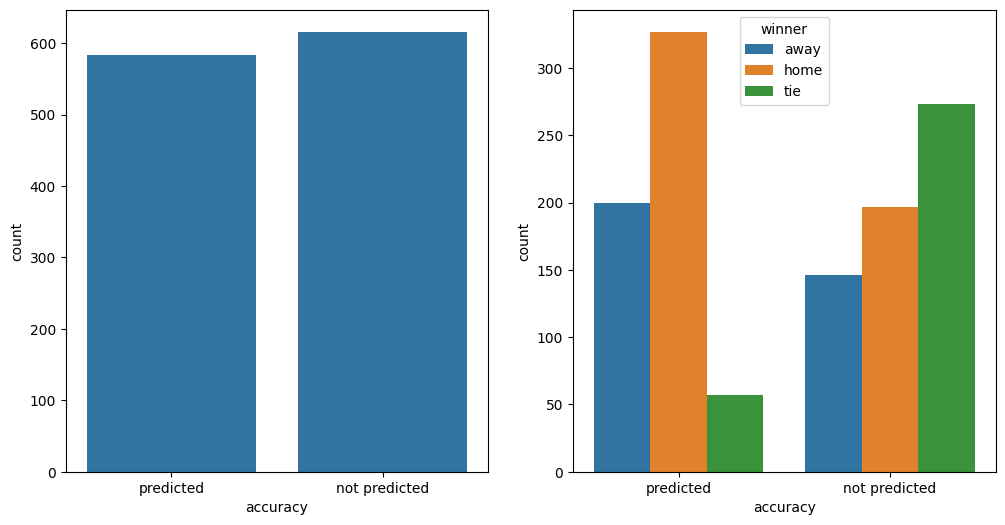

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


sns.countplot(data=test_3_sum, x="accuracy", ax=axes[0])
sns.countplot(data=test_3_sum, x="accuracy", hue='winner', ax=axes[1])

plt.show()

In [29]:
test_3_sum

,match,season,home_team,away_team,winner,league,date,key,home,away,tie,predicted_result,accuracy,day_of_week
451,AtlasTijuana2021-10-28,2022,Atlas,Tijuana,away,MX1,2021-10-28,AtlasTijuana2021-10-28|Atlas|Tijuana,3.9,5.8,3.2,away,predicted,Thursday
5831,TolucaPuebla2022-04-03,2022,Toluca,Puebla,home,MX1,2022-04-03,TolucaPuebla2022-04-03|Toluca|Puebla,6.7,3.2,3.0,home,predicted,Sunday
5829,TolucaPachuca2023-09-03,2024,Toluca,Pachuca,home,MX1,2023-09-03,TolucaPachuca2023-09-03|Toluca|Pachuca,6.9,3.4,2.6,home,predicted,Sunday
3489,LeónGuadalajara2023-04-15,2023,León,Guadalajara,away,MX1,2023-04-15,LeónGuadalajara2023-04-15|León|Guadalajara,4.1,5.0,3.8,away,predicted,Saturday
4349,PachucaUANL2022-10-16,2023,Pachuca,UANL,home,MX1,2022-10-16,PachucaUANL2022-10-16|Pachuca|UANL,4.3,6.4,2.2,away,not predicted,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628,PueblaAmérica2020-09-08,2021,Puebla,América,away,MX1,2020-09-08,PueblaAmérica2020-09-08|Puebla|América,1.9,4.8,6.2,tie,not predicted,Tuesday
6095,UNAMPuebla2023-03-05,2023,UNAM,Puebla,away,MX1,2023-03-05,UNAMPuebla2023-03-05|UNAM|Puebla,3.8,3.7,5.5,tie,not predicted,Sunday
6062,UNAMCruz2021-03-07,2021,UNAM,Cruz,away,MX1,2021-03-07,UNAMCruz2021-03-07|UNAM|Cruz,4.3,6.3,2.3,away,predicted,Sunday
3666,MazatlánUANL2020-08-28,2021,Mazatlán,UANL,tie,MX1,2020-08-28,MazatlánUANL2020-08-28|Mazatlán|UANL,3.5,7.0,2.5,away,not predicted,Friday


In [85]:
df_sum

,Player,#,Nation,Pos,Age,Min,Gls,Ast,PK,PKatt,Sh,SoT,CrdY,CrdR,Touches,Tkl,Int,Blocks,xG,npxG,xAG,SCA,GCA,Cmp,Att,Cmp%,PrgP,Carries,PrgC,Att.1,Succ,team,rival,t_gls,tc_gls,result,formacion,formacion_rival,date,match,location,winner,season,league,code,key,own_ab,rival_db
0,Facundo Batista,9.0,uy URU,FW,24-216,65.0,0,0,0,0,1,0,0,0,18.0,1.0,0,0.0,0.0,0.0,0.0,2.0,0.0,10.0,15.0,66.7,3.0,9.0,1.0,0.0,0.0,Necaxa,UANL,0,3,L,5-4-1,4-2-3-1,2023-08-20,NecaxaUANL2023-08-20,home,away,2024,MX1,31,NecaxaUANL2023-08-20|Necaxa|UANL|MX1,bad,bad
1,Édgar Méndez,7.0,es ESP,FW,33-230,25.0,0,0,0,0,1,0,0,0,12.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,8.0,75.0,0.0,6.0,0.0,1.0,0.0,Necaxa,UANL,0,3,L,5-4-1,4-2-3-1,2023-08-20,NecaxaUANL2023-08-20,home,away,2024,MX1,31,NecaxaUANL2023-08-20|Necaxa|UANL|MX1,bad,bad
2,Daniel Mantilla,10.0,co COL,LM,26-238,65.0,0,0,0,0,2,0,1,0,25.0,0.0,0,0.0,0.4,0.4,0.0,2.0,0.0,11.0,16.0,68.8,1.0,16.0,0.0,1.0,1.0,Necaxa,UANL,0,3,L,5-4-1,4-2-3-1,2023-08-20,NecaxaUANL2023-08-20,home,away,2024,MX1,31,NecaxaUANL2023-08-20|Necaxa|UANL|MX1,bad,bad
3,Braian Samudio,27.0,py PAR,LM,27-240,25.0,0,0,0,0,0,0,0,0,12.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,9.0,66.7,0.0,6.0,0.0,1.0,0.0,Necaxa,UANL,0,3,L,5-4-1,4-2-3-1,2023-08-20,NecaxaUANL2023-08-20,home,away,2024,MX1,31,NecaxaUANL2023-08-20|Necaxa|UANL|MX1,bad,bad
4,Andrés Colorado,5.0,co COL,CM,24-262,65.0,0,0,0,0,0,0,0,0,33.0,2.0,2,0.0,0.0,0.0,0.0,0.0,0.0,21.0,24.0,87.5,2.0,11.0,0.0,2.0,1.0,Necaxa,UANL,0,3,L,5-4-1,4-2-3-1,2023-08-20,NecaxaUANL2023-08-20,home,away,2024,MX1,31,NecaxaUANL2023-08-20|Necaxa|UANL|MX1,bad,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189112,Brayan Vera,4.0,co COL,CB,24-227,90.0,0,1,0,0,3,0,1,0,72.0,4.0,0,4.0,0.1,0.1,0.1,3.0,1.0,47.0,57.0,82.5,5.0,41.0,0.0,2.0,1.0,Real,Portland,1,2,L,4-4-2,4-3-3,2023-08-30,PortlandReal2023-08-30,away,home,2021,MLS,22,PortlandReal2023-08-30|Real|Portland|MLS,mid,bad
189113,Justen Glad,15.0,us USA,CB,26-183,90.0,0,0,0,0,0,0,0,0,68.0,6.0,0,1.0,0.0,0.0,0.0,0.0,0.0,50.0,55.0,90.9,4.0,31.0,0.0,0.0,0.0,Real,Portland,1,2,L,4-4-2,4-3-3,2023-08-30,PortlandReal2023-08-30,away,home,2021,MLS,22,PortlandReal2023-08-30|Real|Portland|MLS,mid,bad
189114,Bode Davis,19.0,us USA,RB,21-189,45.0,0,0,0,0,0,0,0,0,27.0,0.0,0,0.0,0.0,0.0,0.1,3.0,0.0,18.0,26.0,69.2,0.0,12.0,0.0,1.0,1.0,Real,Portland,1,2,L,4-4-2,4-3-3,2023-08-30,PortlandReal2023-08-30,away,home,2021,MLS,22,PortlandReal2023-08-30|Real|Portland|MLS,mid,bad
189115,Carlos Gómez,11.0,co COL,RM,20-352,45.0,0,0,0,0,2,1,0,0,44.0,0.0,1,2.0,0.3,0.3,0.1,7.0,0.0,15.0,28.0,53.6,2.0,33.0,1.0,8.0,5.0,Real,Portland,1,2,L,4-4-2,4-3-3,2023-08-30,PortlandReal2023-08-30,away,home,2021,MLS,22,PortlandReal2023-08-30|Real|Portland|MLS,mid,bad
